# TurboML Exploration

## Set up the environment and install TurboML's SDK.
We use `turboml-installer` to set up the environment for TurboML's SDK.

In [2]:
!pip install -q turboml-installer
import turboml_installer ; turboml_installer.install_on_colab()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
📦 Installing...
🩹 Patching environment...
⏲ Done in 0:01:41
🔁 Restarting kernel...


The kernel should now be restarted with TurboML's SDK installed.

## Login to your TurboML instance

Note that you can copy and replace this snippet with one from your TurboML homepage.

In [1]:
import turboml as tb

tb.init(
  backend_url="https://infrared-barracuda.api.turboml.online",
  api_key="tb_0i3oVRz3StOkYxnfheqmD1j0yoyOJ7ne_d21f21bb"
)

ModuleNotFoundError: No module named 'turboml'

## Inspecting Data

TurboML is built for real-time machine learning, and as such, deals with streams of data. This can be achieved by using connectors to continuously pull data from your data source (like S3  or postgres), or use push-based approaches using REST API or Client SDKs.

For the purpose of this tutorial, we can use simulate real-time data generation, with a batch-like setting using pandas dataframes. Let's first load some pandas dataframes. In this example, we're using a credit card fraud detection dataset.

In [3]:
import pandas as pd

In [4]:
bank_df = pd.read_csv("bank.csv")

In [4]:
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [5]:
bank_df['primary_key'] = bank_df.index
labels_df = bank_df[['primary_key','deposit']]
bank_df = bank_df.drop('deposit', axis=1)


Our dataset has 11162 datapoints, each with a corresponding label i.e. deposit.

In [6]:
labels_df

,primary_key,deposit
0,0,yes
1,1,yes
2,2,yes
3,3,yes
4,4,yes
...,...,...
11157,11157,no
11158,11158,no
11159,11159,no
11160,11160,no


## Data Ingestion

We can now upload these dataframes to the TurboML platform, the **OnlineDataset** class can be used here. It takes in the dataframe, the primary key,  and the name of the dataset that is to be created for the given dataframe as input.

In [6]:
# Attempt to create and upload dataset
bank = tb.OnlineDataset.from_pd(
    id="bank_data",
    df=bank_df,
    key_field="primary_key",
    load_if_exists=True,
)
labels = tb.OnlineDataset.from_pd(
    id="qs_transaction_labels",
    df=labels_df,
    key_field="primary_key",
    load_if_exists=True,
)

## Feature Engineering

TurboML platform facilitates transformations on raw data to produce new features. You can use the jupyter notebook as a "playground" to explore different features. This involves 3 steps.
- **fetch data**: Experimentation is easier on static data. Since TurboML works with continuous data streams, to enable experimentation we fetch a snapshot or a subset of data in the jupyter notebook.
- **add feature definitions**: Now that we have a static dataset, we can define multiple different features, and see their values on this dataset. Since we can observe their values, we can perform simple experiments and validations like correlations, plots and other exploratory analysis.
- **submit feature definitions**: Once we're confident about the features we've defined, we can now submit the ones we want TurboML to compute continuously for the actual data stream.

### Fetch data

We can use the **get_features** function to get a snapshot or subset of the data stream.

**Note**: This size of the dataset returned by this function can change on each invocation. Also, the dataset is not guaranteed to be in the same order.

### Add feature definitions

To add feature definitions, we have a class from turboml package called **FeatureEngineering**. This allows us to define SQL-based and dynamic aggregation-based features.

The following cell shows how to define an SQL-based feature. The sql_definition parameter in the **create_sql_features** function takes in the SQL expression to be used to prepare the feature. It returns a dataframe with all the original columns, and another column which, on a high-level is defined as ```SELECT sql_definition AS new_feature_name FROM dataframe```.

In [8]:
bank.feature_engineering.create_sql_features(
    sql_definition='',
    new_feature_name="my_sql_feat",
)

BinderException: Binder Error: Referenced column "transactionAmount" not found in FROM clause!
Candidate bindings: "dataframe.poutcome", "dataframe.education", "dataframe.loan", "dataframe.marital", "dataframe.contact"

In [7]:
bank.feature_engineering.get_local_features()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,primary_key
0,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,2
1,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,5
2,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,9
3,30,blue-collar,married,secondary,no,309,yes,no,unknown,7,may,1574,2,-1,0,unknown,11
4,29,management,married,tertiary,no,199,yes,yes,unknown,7,may,1689,4,-1,0,unknown,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,60,retired,divorced,tertiary,no,-134,no,no,cellular,12,may,243,1,271,4,failure,11145
11158,34,management,married,secondary,no,355,no,no,cellular,21,aug,314,3,-1,0,unknown,11150
11159,34,housemaid,married,secondary,no,390,yes,no,cellular,15,jul,659,3,-1,0,unknown,11152
11160,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,11159


In [ ]:
#Lets create a train test split


### Submit feature definitions

Now that we've seen the newly created features, and everything looks good, we can submit these feature definitions to the TurboML platform so that this can be computed continously for the input data stream.

We need to tell the platform to start computations for all pending features for the given dataset. This can be done by calling the **materialize_features** function.

In [11]:
transactions.feature_engineering.materialize_features(["my_sql_feat", "my_sum_feat"])

In [12]:
df_transactions = transactions.feature_engineering.get_materialized_features()
df_transactions

,transactionID,accountID,transactionAmount,transactionCurrencyCode,transactionDate,transactionTime,localHour,transactionIPaddress,timestamp,transactionAmountUSD,...,browserLanguage,paymentInstrumentType,cardType,paymentBillingPostalCode,paymentBillingState,paymentBillingCountryCode,digitalItemCount,physicalItemCount,my_sql_feat,my_sum_feat
0,0000225D-F0A8-40E5-80EC-362040E3F5E0,A1759222196750620,1.56,CAD,20130616,150417,0.0,131.107,1.371395e+09,1.553557,...,en-CA,CREDITCARD,VISA,V5Y 1X7,BC,CA,1.0,0.0,1.56,1.56
1,0000AD08-C86D-4ACD-AB98-6A3DFC036C3F,A844427159791657,99.00,AUD,20130720,83104,18.0,144.132,1.374309e+09,103.489650,...,en-AU,PAYPAL,,,,AU,1.0,0.0,117.00,99.00
2,0002D6F2-3E9D-453E-BF48-1FB8BD7BD04A,A985156453533990,109.99,GBP,20130418,75304,7.0,86.171,1.366272e+09,173.223251,...,en-GB,PAYPAL,,,,GB,1.0,0.0,116.99,109.99
3,00049EF5-0367-4EE6-9D65-0973F11AF4DA,A1055521444510900,104.99,USD,20130709,192915,14.0,184.153,1.373398e+09,104.990000,...,en-US,CREDITCARD,VISA,4005,ME,US,1.0,0.0,118.99,104.99
4,00057336-AA8F-45AA-AE5E-950E97FACF78,A1055520791219040,86.95,USD,20130830,30026,20.0,174.450,1.377832e+09,86.950000,...,en-US,CREDITCARD,VISA,66049,KS,US,1.0,0.0,106.95,86.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,FFF6E021-A503-4D34-936E-603CC11555DD,A914800564799399,469.99,LTL,20130721,124352,14.0,62.212,1.374411e+09,183.461066,...,lt-LT,CREDITCARD,MC,1309,,LT,1.0,0.0,483.99,469.99
199996,FFF8BB86-5170-4224-A9EA-1F71B0356CB0,A985156261852043,4.99,USD,20130526,82858,8.0,91.125,1.369557e+09,4.990000,...,en-US,PAYPAL,,,,GB,1.0,0.0,12.99,4.99
199997,FFF97DF8-F3B4-4A89-8749-AD141E4D40DA,A2111055914491240,39.99,USD,20130901,143500,9.0,173.750,1.378046e+09,39.990000,...,en-US,CREDITCARD,VISA,19808,DE,US,0.0,1.0,48.99,39.99
199998,FFFB3106-92C4-4ACC-903E-3BFCDE585A91,A2181420352010050,105.99,USD,20130507,647,19.0,184.150,1.367885e+09,105.990000,...,en-US,CREDITCARD,VISA,25213,WV,US,1.0,0.0,124.99,105.99


## Machine Learning Modelling

TurboML provides out of the box algorithms, optimized for real-time ML, and supports bringing your own models and algorithms as well. In this tutorial, we'll use the algorithms provided by TurboML.

### Check the available algorithms

You can check what are the available ML algorithms based on `tb.ml_algorithms(have_labels=True/False)` depending on supervised or unsupervised learning.

In [13]:
tb.ml_algorithms(have_labels=False)

['MStream', 'RCF', 'HST', 'ONNX']

Let's use the RandomCutForest (RCF) algorithm.

### Create model

Now that we've chosen an algorithm, we need to create a model.

In [14]:
model = tb.RCF(number_of_trees=50)

### Run Streaming ML jobs
Now that we've instantiated the model, we can deploy it using the **deploy** function.
For an unsupervised ML job, we need to provide a dataset from which the model can consume inputs. For each record in this dataset, the model will make a prediction, produce the prediction to an output dataset, and then perform unsupervised updates using this record.

There are four types of fields that can be used by any ML algorithm:

  - numerical_fields: This represents fields that we want our algorithm to treat as real-valued fields.
  - categorical_fields: This represents fields that we want our algorithm to treat as categorical fields.
  - time_field: This is used for time-series applications to capture the timestamp field.
  - textual_fields: This represents fields that we want our algorithm to treat as text fields.

The input values from any of these fields are suitably converted to the desired type. String values are converted using the hashing trick.

Let's construct a model config using the following numerical fields, no categorical or time fields.

In [15]:
numerical_fields = [
    "transactionAmount",
    "localHour",
    "my_sum_feat",
    "my_sql_feat",
]
features = transactions.get_model_inputs(numerical_fields=numerical_fields)
label = labels.get_model_labels(label_field="is_fraud")

In [18]:
deployed_model_rcf = model.deploy(name="demo_model_rcf1", input=features, labels=label)

### Inspect model outputs

We can now fetch the outputs that the model produced by calling the **get_outputs** function.

**Note**: This size of the outputs returned by this function can change on each invocation, since the model is continuosly producing outputs.  

In [22]:
outputs = deployed_model_rcf.get_outputs()

INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 0 seconds
INFO:turboml.common.dataloader:Yielded 200000 records (40 batches) in 2 seconds


In [20]:
len(outputs)

200000

In [23]:
sample_output = outputs[-1]
sample_output

{'offset': 199999,
 'record': key: "FF9A22DA-2299-4D05-943E-DBD9C4A46E48"
 score: 0.541451931
 feature_score: 0.333333373
 feature_score: 0.181159422
 feature_score: 0.333333373
 feature_score: 0.152173817}

The above output corresponds to an input with the key, or index, sample_output.key. Along with the anomaly score, the output also contains attributions to different features. We can see that the first numerical feature, i.e. 'transactionAmount' is around sample_output.feature_score[0]*100% responsible for the anomaly score

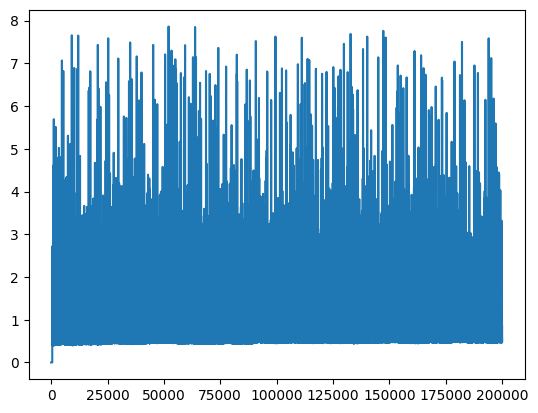

In [24]:
import matplotlib.pyplot as plt

plt.plot([output["record"].score for output in outputs])

### Model Endpoints

The above method of interacting with the model was asynchronous. We were adding our datapoints to an input dataset, and getting the corresponding model outputs in an output dataset. In some scenarios, we need a synchronous method to query the model. This is where we can use the model endpoints that TurboML exposes.

In [25]:
model_endpoints = deployed_model_rcf.get_endpoints()
model_endpoints

['https://infrared-barracuda.api.turboml.online/model/_turboml.demo_model_rcf1/predict']

Now that we know what endpoint to send the request to, we now need to figure out the right format. Let's try to make a prediction on the last row from our input dataset.

In [26]:
model_query_datapoint = transactions_df.iloc[-1].to_dict()
model_query_datapoint

{'transactionID': 'B15BAF24-E87A-449A-9AA8-0E6004B22355',
 'accountID': 'A985156974500548',
 'transactionAmount': 148.39,
 'transactionCurrencyCode': 'USD',
 'transactionDate': 20130930,
 'transactionTime': 235910,
 'localHour': 18.0,
 'transactionIPaddress': 198.47,
 'timestamp': 1380585550.0,
 'transactionAmountUSD': 148.39,
 'ipState': 'michigan',
 'ipPostcode': '49026',
 'ipCountryCode': 'us',
 'isProxyIP': 0.0,
 'browserLanguage': 'en-US',
 'paymentInstrumentType': 'CREDITCARD',
 'cardType': 'MC',
 'paymentBillingPostalCode': '49026',
 'paymentBillingState': 'MI',
 'paymentBillingCountryCode': 'US',
 'digitalItemCount': 1.0,
 'physicalItemCount': 0.0}

In [ ]:
import requests

resp = requests.post(
    model_endpoints[0], json=model_query_datapoint, headers=tb.common.api.headers
)

In [ ]:
resp.json()

### Batch Inference on Models

While the above method is more suited for individual requests, we can also perform batch inference on the models. We use the **get_inference** function for this purpose.

In [28]:
outputs = deployed_model_rcf.get_inference(transactions_df)
outputs

INFO:turboml.common.internal:Starting to upload data... Total rows: 200000
Progress:  95%|█████████▌| 20.0/21.0 [00:04<00:00, 4.08chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 200000
Progress: 100%|██████████| 196/196 [00:00<00:00, 236chunk/s]
INFO:turboml.common.internal:Completed data upload.


,score,feature_score
0,0.575701,"[0.05670683, 0.41493976, 0.05670683, 0.47164655]"
1,0.622891,"[0.33333334, 0.33333334, 0.33333334, 0.0]"
2,0.671387,"[0.0, 0.5, 0.0, 0.5]"
3,0.607292,"[0.28804353, 0.06793471, 0.28804353, 0.35597828]"
4,0.676388,"[0.0, 0.5, 0.0, 0.5]"
...,...,...
199995,0.552935,"[0.33333334, 0.21163958, 0.33333334, 0.12169373]"
199996,0.516712,"[0.0, 0.5, 0.0, 0.5]"
199997,0.697162,"[0.33333334, 0.13333334, 0.33333334, 0.19999999]"
199998,0.531707,"[0.25, 0.25, 0.25, 0.25]"


## Model Evaluation

Similar to ML models, TurboML provides in-built metrics, and supports defining your own metrics. Let's see the available metrics.

In [ ]:
tb.evaluation_metrics()

We can select the AreaUnderCurve (AUC) metric to evaluate our anomaly detection model. The windowed prefix means we're evaluating these metrics over a rolling window. By default, the window size is `1000`.

In [29]:
deployed_model_rcf.add_metric("WindowedAUC")

Similar to steps like feature engineering and ML modelling, model evaluation is also a continuosly running job. We can look at the snapshot of the model metrics at any given instance by using the **get_evaluation** function.

**Note**: This size of the outputs returned by this function can change on each invocation, since we're continuously evaluating the model.  

In [30]:
model_auc_scores = deployed_model_rcf.get_evaluation("WindowedAUC")
model_auc_scores[-1]

index: 200
metric: 0.314553976

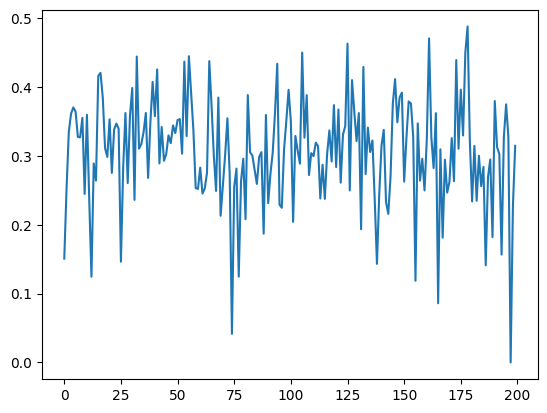

In [31]:
import matplotlib.pyplot as plt

plt.plot([model_auc_score.metric for model_auc_score in model_auc_scores])

### Model Evaluation with filter and custom window size

We support running evaluation on filtered model data using valid SQL expression along with custom window size.

In [32]:
model_auc_scores = deployed_model_rcf.get_evaluation(
    "WindowedAUC",
    filter_expression="input_data.transactionCurrencyCode != 'USD' AND output_data.score > 0.6",
    window_size=200,
)
model_auc_scores[-1]

index: 172
metric: 0.410256416

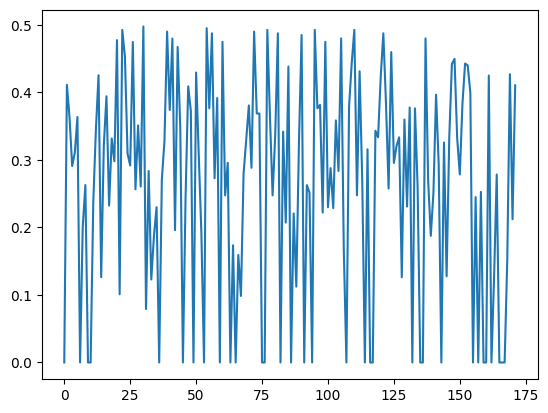

In [33]:
import matplotlib.pyplot as plt

plt.plot([model_auc_score.metric for model_auc_score in model_auc_scores])

## Supervised Learning

Let's now take an example with a supervised learning algorithm. First, let's see what algorithms are supported out of the box.

In [ ]:
tb.ml_algorithms(have_labels=True)

We can use HoeffdingTreeClassifier to try to classify fraudulent and normal activity on the same dataset. First, we need to instantiate a model.

In [34]:
htc_model = tb.HoeffdingTreeClassifier(n_classes=2)

We can use the same numerical fields in this model as well. However, let's add some categorical fields as well.

In [35]:
categorical_fields = [
    "digitalItemCount",
    "physicalItemCount",
    "isProxyIP",
]
features = transactions.get_model_inputs(
    numerical_fields=numerical_fields, categorical_fields=categorical_fields
)
label = labels.get_model_labels(label_field="is_fraud")

### Run Supervised ML jobs
Same as before, we can deploy this model with the **deploy** function.

In [37]:
deployed_model_htc = htc_model.deploy("demo_classifier1", input=features, labels=label)

We can now inspect the outputs.

In [38]:
outputs = deployed_model_htc.get_outputs()

INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 0 seconds
INFO:turboml.common.dataloader:Yielded 200000 records (40 batches) in 3 seconds


In [ ]:
len(outputs)

In [39]:
sample_output = outputs[-1]
sample_output

{'offset': 199999,
 'record': key: "FF9A22DA-2299-4D05-943E-DBD9C4A46E48"
 score: 0.00245700241
 class_probabilities: 0.997543
 class_probabilities: 0.00245700241
 predicted_class: 0}

We notice that since this is a classification model, we have some new attributes in the output, specifically `class_probabilities` and `predicted_class`. We also have the `score` attribute which, for classification, just shows us the probability for the last class.

### Supervised Model Endpoints
Predict API for supervised models is exactly the same as unsupervised models.

In [40]:
model_endpoints = deployed_model_htc.get_endpoints()
model_endpoints

['https://infrared-barracuda.api.turboml.online/model/_turboml.demo_classifier1/predict']

In [41]:
resp = requests.post(
    model_endpoints[0], json=model_query_datapoint, headers=tb.common.api.headers
)
resp.json()

NameError: name 'requests' is not defined

### Supervised Model Evaluation
Let's now evaluate our supervised ML model. The process is exactly the same as for unsupervised model evaluation.

In [ ]:
deployed_model_htc.add_metric("WindowedAUC")

We can use the same **get_evaluation** function to fetch the metrics for this model as well. Remember, this function retrieves the metric values present at that moment of time. So, if the number of records recieved seem low, just re-run this function.  

In [ ]:
model_auc_scores = deployed_model_htc.get_evaluation("WindowedAUC")
model_auc_scores[-1]

In [ ]:
plt.plot([model_auc_score.metric for model_auc_score in model_auc_scores])

## Model Comparison

Now that we have 2 models deployed, and we've registered metrics for both of them, we can compare them on real-time data. On each invocation, the following function will fetch the latest evaluations of the models and plot them.

In [ ]:
tb.compare_model_metrics(
    models=[deployed_model_rcf, deployed_model_htc], metric="WindowedAUC"
)

## Model Deletion

We can delete the models like this, by default the generated output is deleted. If you want to retain the output generated by model, use `delete_output_topic=False`.

In [ ]:
deployed_model_rcf.delete()